In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports:

In [ ]:
!pip install contractions
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 5.5 MB/s 
     |████████████████████████████████| 110 kB 52.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 8.1 MB/s 


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/')
!ls

'1. Intro and EDA.ipynb'		      data_sampled.csv	 notebooks
'2. Preprocessing and Model Training.ipynb'   featurizers	 __pycache__
'3. Final.ipynb'			      model_images	 streamlit_app
 blog					      model_logs	 train_df.csv
 data.csv				      model_save	 val_df.csv


In [ ]:
import os
import re
import joblib
import shutil
import contractions

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import vgg16, resnet50

# import tokenization - The tokenization.py file can be found here: https://github.com/google-research/bert/blob/master/tokenization.py
from featurizers import tokenization 

In [ ]:
os.chdir('../../../../../..')
!ls

drive		   glove.6B.zip  v2_Annotations_Train_mscoco
glove.6B.300d.txt  train2014	 v2_Questions_Train_mscoco


# Loading data:

In [ ]:
!wget http://images.cocodataset.org/zips/train2014.zip
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip

# downloading GLOVE word embeddings and unzipping
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
!7z x train2014.zip -o*
!7z x v2_Questions_Train_mscoco.zip -o*
!7z x v2_Annotations_Train_mscoco.zip -o*
!unzip glove.6B.zip

shutil.rmtree("sample_data")

os.remove("train2014.zip")
os.remove("v2_Questions_Train_mscoco.zip")
os.remove("v2_Annotations_Train_mscoco.zip")
os.remove("glove.6B.50d.txt")
os.remove("glove.6B.100d.txt")
os.remove("glove.6B.200d.txt")

In [ ]:
# load the data
data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/train_df.csv')
data_df.shape

(40000, 6)

# Final prediction pipeline:

Varaints of vanilla VQA model explored in this case study:

1. **Model-1**: VGG16 to featurize the image and LSTM with Glove word embeddings
to featurize the questions.
2. **Model-2**: ResNet50 to featurize the image and BERT embeddings to featurize the questions. 

**Common Helpers to both the models:**

In [ ]:
MAX_SEQUENCE_LENGTH = 22
IMG_TARGET_SIZE = (224, 224)

# Function to clean the questions
def clean_text(text):
    """
    Clean the text by fixing contractions, lowering the text and removing 
    any special characters.
    """
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    return text

In [ ]:
# One-Hot Encoder fitted on 1-word answers in the dataset
ohe = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/featurizers/ohe.joblib")

### Model-1:

**Loading all the necessary objects:**

In [ ]:
# Model
model_1 = load_model('/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/model_save/best_model_1.h5')

# ==============================================================================
# Tokenizer
tknizr_model_1 = joblib.load("/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/featurizers/tknizr.joblib")
# indices for each of the word in the vocab
WORD_INDEX = tknizr_model_1.word_index
# vocab size (no. of all tokens in the text(questions) train data)
VOCAB_SIZE = len(WORD_INDEX) + 1 # +1 because all the indices we get are starting from 1 but after padding we also add 0 so total=len(word_index)+1

# ==============================================================================
# Text Embedding layer
# load the whole GLOVE embedding into memory
# Ref: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
EMBEDDING_DIM = 300

embeddings_index = dict()
f = open('./glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in WORD_INDEX.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Embedding layer
glove_embedding_layer = Embedding(
    VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], 
    input_length=MAX_SEQUENCE_LENGTH, name='GLOVE_embedding_layer', 
    trainable=False
)

# ==============================================================================
# VGG16 Featurizer. 
# The weights obtained are a result of training on 'imagenet' dataset. 
vgg16_model = vgg16.VGG16(
    weights='imagenet', 
    input_shape=IMG_TARGET_SIZE+ (3,), #`input_shape` must be a tuple of three integers. The input must have 3 channels if weights = 'imagenet'
)
vgg16_model.trainable = False

# Create a model that outputs activations from vgg16's last hidden layer
vgg_featurizer = Model(
    inputs=vgg16_model.inputs, outputs=vgg16_model.layers[-2].output)
vgg_featurizer.trainable = False

553467096/553467096 [==============================] - 20s 0us/step


#### Preprocessing and Featurization of the data:

**Helper functions:**

In [ ]:
def encode_questions_model_1(tknizr, embd_layer, text, seq_len):
    """Encode text data.

    Parameters:
    -----------
    tknizr: tensorflow.keras.preprocessing.text.Tokenizer
        Tokenizer to convert text to int sequences.

    embd_layer: tensorflow.keras.layers.Embedding
        tf keras Embedding layer to embed sequence.

    text: str
        Question to encode.
    
    seq_len: int
        max sequence length to pad the sequence to.

    Returns:
    --------
    encoded_sequence: tf.Tensor
        Encoded text sequence
    """
    # clean the text
    text = clean_text(text)
    # converting to int sequences using the tokenizer
    encoded_seq = tknizr.texts_to_sequences([text]) # need to pass list of values
    # padding sequences to seq_len
    encoded_seq = pad_sequences(
        encoded_seq, maxlen=seq_len, dtype='int32', padding='post'
    )
    # embed using the Embedding layer
    encoded_seq = embd_layer(encoded_seq)

    return encoded_seq

# ==============================================================================
def preprocess_images_model_1(img_path, target_size):
    """Preprocess images.

    Parameters:
    -----------
    img_path: str 
        Path to image file

    target_size: tuple(height, width)
        Size to load the image.

    Returns:
    --------
    img_arr: np.ndarray
        Preprocessed image as np array
    """
    img = image.load_img(img_path, target_size=target_size)
    img_arr = image.img_to_array(img)
    # The images are converted from RGB to BGR, 
    # then each color channel is zero-centered with respect to the ImageNet dataset, 
    # without scaling.
    img_arr = vgg16.preprocess_input(img_arr)
    
    return img_arr

def encode_images_model_1(vgg_featurizer, img_path, target_size):
    """Encode image data.

    Parameters:
    -----------
    vgg_featurizer: tensorflow.keras.models.Model
       Model from which the activations of last hidden layer in vgg16 can be extracted.

    img_path: str
        Path to image file.
    
    target_size: tuple(height, width)
        Size to load the image.

    Returns:
    --------
    vgg_feats: tf.Tensor
        Activations from last hidden layer of vgg16 model.
    """
    # preprocess the image
    img_arr = preprocess_images_model_1(img_path, target_size)
    # vgg_featurizer
    vgg_feats = vgg_featurizer(np.expand_dims(img_arr, axis=0))
    
    return vgg_feats

#### Prediction Function:

In [ ]:
def produce_ans_model_1(X):
    """
    Produce the answer for a question asked about an image using model_1.
    
    Parameters:
    -----------
    X: pandas.DataFrame
        Dataframe containing path to the image and a corresponding question. 
        This have a single row or a set of row. 
    
    Returns:
    --------
    Pred_df: pandas.DataFrame
        Dataframe containing path to image, corresponding question and the 
        answer generated to it by model 1.
    """
    pred_df = X.copy()
    pred_ans = []
    # iterate through each row and generate answers
    for i in tqdm(range(len(X))):
        row_df = X.iloc[i]
        # encode the questions using the "encode_questions_model_1" funtion defined earlier
        enc_seq = encode_questions_model_1(
            tknizr_model_1, glove_embedding_layer, row_df['question'], MAX_SEQUENCE_LENGTH)[0]
        # encode the images using the "encode_images_model_1" funtion defined earlier
        vgg_feats = encode_images_model_1(
            vgg_featurizer, row_df['image_path'], IMG_TARGET_SIZE)[0]
        # generate answer
        y_pred_val = model_1([np.asarray([enc_seq]), np.asarray([vgg_feats])])
        y_pred_val = ohe.inverse_transform(tf.one_hot(tf.argmax(y_pred_val, axis=1), depth=len(ohe.categories_[0])))[0][0]
        # store pred ans
        pred_ans.append(y_pred_val)
    pred_df["pred_answer"] = pred_ans
            
    return pred_df

#### Accuracy Function:

In [ ]:
def accuracy_model_1(X, y):
    """
    Returns the accuracy of the predictions made by model-1.

    Parameters
    ----------
    X: pandas.DataFrame
        Dataframe containing path to the image and a corresponding question. 
        This have a single row or a set of row. 
    
    y: pandas.Series
        Groundth truth data for the input X.

    Returns:
    --------
    rmsle: float
        Accuracy value calculated for predictions made by model-1.
    """
    pred_df = produce_ans_model_1(X)
    acc = accuracy_score(y.values, pred_df['pred_answer'].values)
    return acc

#### Example:

In [ ]:
data_df[2:4]

,image_path,question,question_type,multiple_choice_answer,answers,answer_type
2,train2014/train2014/COCO_train2014_00000025027...,is there a balloon in the sky,is there a,yes,"['yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes...",yes/no
3,train2014/train2014/COCO_train2014_00000051353...,is this a race,is this a,no,"['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no...",yes/no


In [ ]:
pred_df = produce_ans_model_1(data_df[2:4])
pred_df

  0%|          | 0/2 [00:00<?, ?it/s]

,image_path,question,question_type,multiple_choice_answer,answers,answer_type,pred_answer
2,train2014/train2014/COCO_train2014_00000025027...,is there a balloon in the sky,is there a,yes,"['yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes...",yes/no,yes
3,train2014/train2014/COCO_train2014_00000051353...,is this a race,is this a,no,"['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no...",yes/no,yes


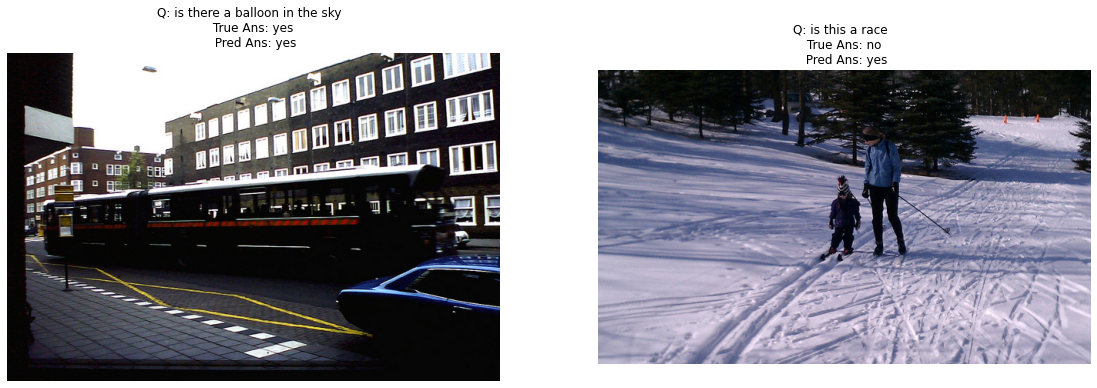

In [ ]:
plt.figure(figsize=(30, 15))
for i in range(len(pred_df)):
    plt.subplot(np.ceil(len(pred_df)/3), 3, i+1)
    img = mpimg.imread(pred_df.iloc[i]['image_path'])
    plt.imshow(img)
    plt.title(
        f"Q: {pred_df.iloc[i]['question']} \n True Ans: {pred_df.iloc[i]['multiple_choice_answer']} \n Pred Ans: {pred_df.iloc[i]['pred_answer']}")
    plt.axis('off')

In [ ]:
acc = accuracy_model_1(data_df[2:4], data_df[2:4]["multiple_choice_answer"])
print("Accuracy: ", acc)

  0%|          | 0/2 [00:00<?, ?it/s]

Accuracy:  0.5


## Model-2

**Loading all the necessary objects:**

In [ ]:
# Model
model_2 = load_model('/content/drive/MyDrive/Colab Notebooks/AppliedAI/Assignments/CS-2-VQA/model_save/best_model_2.h5')

# ==============================================================================
# Bert Featurizer
# BERT takes 3 inputs:
# this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_word_ids")
# mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_mask")
# segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
# If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
# second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="segment_ids")

# bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

# Bert model
# We are using only pooled output not sequence out. 
# If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_featurizer = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

# ==============================================================================
# Tokenizer
# getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
# Create tokenizer "Instantiate FullTokenizer" 
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )
# please check the "tokenization.py" file the complete implementation
tknizr_model_2 = tokenization.FullTokenizer(vocab_file, do_lower_case)

# ==============================================================================
# ResNet50 featurizer, 
# Since below I use pretrained model weights. 
# The weights obtained are a result of training on 'imagenet' dataset. 
resnet50_model = resnet50.ResNet50(
    weights='imagenet', 
    input_shape=IMG_TARGET_SIZE+ (3,), #`input_shape` must be a tuple of three integers. The input must have 3 channels if weights = 'imagenet'
)
resnet50_model.trainable = False

# Create a model that outputs activations from resnet50's last hidden layer
resnet50_featurizer = Model(
    inputs=resnet50_model.inputs, outputs=resnet50_model.layers[-2].output)
resnet50_featurizer.trainable = False

102967424/102967424 [==============================] - 4s 0us/step


#### Preprocessing and Featurization of the data:

**Helper functions:**

In [ ]:
# Create train and test tokens (train_tokens, test_tokens) from (train, test) using Tokenizer and 
# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 

# maximum number of tokens is 22(MAX_SEQUENCE_LENGTH) so shape is (None, 22)
# if it is less than 22, add '[PAD]' token else truncate the tokens length.(similar to padding)

# Based on padding, create the mask for Train and Test (1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 22) save those in train_mask, test_mask

# Create a segment input for train and test. We are using only one sentence so all zeros. 
# This shape will also (None, 22)

# Type of all the above arrays should be numpy arrays
def get_tokens_masks_segments(tokenizer, text, max_seq_length):

    # ==========================Get tokens======================================
    tokens = tokenizer.tokenize(text) # tokenize the text

    #Adding [CLS] and [SEP] tokens:
    # if len of tokens is greater that max_len-2 the truncate to max_len-2
    if (len(tokens) > (max_seq_length-2)):
        tokens = tokens[0:(max_seq_length-2)]

    tokens = ['[CLS]', *tokens, '[SEP]']

    # Padding if len of tokens after adding [CLS] and [SEP] tokens is still less than max_len
    if (len(tokens) < max_seq_length):
        tokens.extend(['[PAD]']*(max_seq_length-len(tokens)))

    # convert token to ids
    # ['[CLS]', 'Let', "'", 's', 'learn', 'deep', 'learning', '!', '[SEP]', '[PAD]']
    # # Converting to IDs
    # [101, 2421, 112, 188, 3858, 1996, 3776, 106, 102, 0]
    tokens = tokenizer.convert_tokens_to_ids(tokens)

    # ==========================Get Masks=======================================
    if 0 in tokens:
        pos = tokens.index(0)
        masks = [1]*pos + [0]*(max_seq_length - pos)
    else:
        masks = [1]*max_seq_length

    # ==========================Get Segment vectors=============================
    segments = [0]*max_seq_length

    # ==========================================================================
    return np.array(tokens), np.array(masks), np.array(segments)

def encode_questions_model_2(tknizr, bert_featurizer, text, seq_len):
    """Encode text data.

    Parameters:
    -----------
    tknizr: obj
        Tokenizer to tokenize text.

    bert_featurizer: tensorflow.keras.model.Model
        tf keras Model to embed the sequence.

    text: str
        Question to encode.
    
    seq_len: int
        max sequence length to pad the sequence to.

    Returns:
    --------
    pooled_output: tf.Tensor
        Encoded text sequence
    """
    # clean the text
    text = clean_text(text)
    # tokenizing
    tokens, mask, segment = get_tokens_masks_segments(tknizr, text, seq_len)
    # embed using the bert featurizer
    pooled_output = bert_featurizer([
        np.expand_dims(tokens, axis=0), 
        np.expand_dims(mask, axis=0), 
        np.expand_dims(segment, axis=0)
    ])

    return pooled_output

# ==============================================================================
def preprocess_images_model_2(img_path, target_size):
    """Preprocess images.

    Parameters:
    -----------
    img_path: str 
        Path to image file

    target_size: tuple(height, width)
        Size to load the image.

    Returns:
    --------
    img_arr: np.ndarray
        Preprocessed image as np array
    """
    img = image.load_img(img_path, target_size=target_size)
    img_arr = image.img_to_array(img)
    # The images are converted from RGB to BGR, 
    # then each color channel is zero-centered with respect to the ImageNet dataset, 
    # without scaling.
    img_arr = resnet50.preprocess_input(img_arr)
    
    return img_arr

def encode_images_model_2(resnet50_featurizer, img_path, target_size):
    """Encode image data.

    Parameters:
    -----------
    resnet50_featurizer: tensorflow.keras.models.Model
       Model from which the activations of last hidden layer in resnet50 can be extracted.

    img_path: str
        Path to image file.
    
    target_size: tuple(height, width)
        Size to load the image.

    Returns:
    --------
    resnet50_feats: tf.Tensor
        Activations from last hidden layer of resnet50 model.
    """
    # preprocess the image
    img_arr = preprocess_images_model_2(img_path, target_size)
    # resnet50_featurizer
    resnet50_feats = resnet50_featurizer(np.expand_dims(img_arr, axis=0))
    
    return resnet50_feats

#### Prediction Function:

In [ ]:
def produce_ans_model_2(X):
    """
    Produce the answer for a question asked about an image using model_2.
    
    Parameters:
    -----------
    X: pandas.DataFrame
        Dataframe containing path to the image and a corresponding question. 
        This have a single row or a set of row. 
    
    Returns:
    --------
    Pred_df: pandas.DataFrame
        Dataframe containing path to image, corresponding question and the 
        answer generated to it by model 2.
    """
    pred_df = X.copy()
    pred_ans = []
    # iterate through each row and generate answers
    for i in tqdm(range(len(X))):
        row_df = X.iloc[i]
        # encode the questions using the "encode_questions_model_2" funtion defined earlier
        enc_seq = encode_questions_model_2(
            tknizr_model_2, bert_featurizer, row_df['question'], MAX_SEQUENCE_LENGTH)[0]
        # encode the images using the "encode_images_model_2" funtion defined earlier
        resnet_feats = encode_images_model_2(
            resnet50_featurizer, row_df['image_path'], IMG_TARGET_SIZE)[0]
        # generate answer
        y_pred_val = model_2([np.asarray([enc_seq]), np.asarray([resnet_feats])])
        y_pred_val = ohe.inverse_transform(tf.one_hot(tf.argmax(y_pred_val, axis=1), depth=len(ohe.categories_[0])))[0][0]
        pred_ans.append(y_pred_val)
    pred_df["pred_answer"] = y_pred_val
            
    return pred_df

#### Accuracy Function:

In [ ]:
def accuracy_model_2(X, y):
    """
    Returns the accuracy of the predictions made by model-2.

    Parameters
    ----------
    X: pandas.DataFrame
        Dataframe containing path to the image and a corresponding question. 
        This have a single row or a set of row. 
    
    y: pandas.Series
        Groundth truth data for the input X.

    Returns:
    --------
    rmsle: float
        Accuracy value calculated for predictions made by model-2.
    """
    pred_df = produce_ans_model_2(X)
    acc = accuracy_score(y.values, pred_df['pred_answer'].values)
    return acc

#### Example:

In [ ]:
data_df[2:4]

,image_path,question,question_type,multiple_choice_answer,answers,answer_type
2,train2014/train2014/COCO_train2014_00000025027...,is there a balloon in the sky,is there a,yes,"['yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes...",yes/no
3,train2014/train2014/COCO_train2014_00000051353...,is this a race,is this a,no,"['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no...",yes/no


In [ ]:
pred_df = produce_ans_model_2(data_df[2:4])
pred_df

  0%|          | 0/2 [00:00<?, ?it/s]

,image_path,question,question_type,multiple_choice_answer,answers,answer_type,pred_answer
2,train2014/train2014/COCO_train2014_00000025027...,is there a balloon in the sky,is there a,yes,"['yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes...",yes/no,yes
3,train2014/train2014/COCO_train2014_00000051353...,is this a race,is this a,no,"['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no...",yes/no,yes


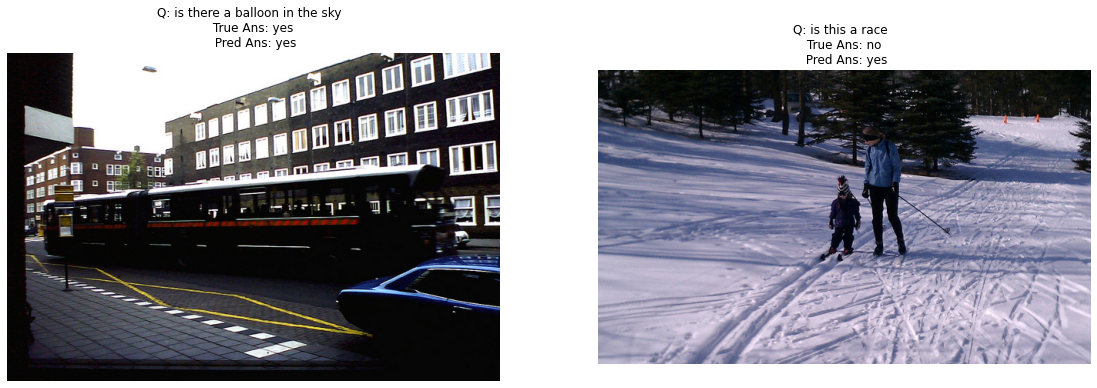

In [ ]:
plt.figure(figsize=(30, 15))
for i in range(len(pred_df)):
    plt.subplot(np.ceil(len(pred_df)/3), 3, i+1)
    img = mpimg.imread(pred_df.iloc[i]['image_path'])
    plt.imshow(img)
    plt.title(
        f"Q: {pred_df.iloc[i]['question']} \n True Ans: {pred_df.iloc[i]['multiple_choice_answer']} \n Pred Ans: {pred_df.iloc[i]['pred_answer']}")
    plt.axis('off')

In [ ]:
acc = accuracy_model_2(data_df[2:4], data_df[2:4]["multiple_choice_answer"])
print("Accuracy: ", acc)

  0%|          | 0/2 [00:00<?, ?it/s]

Accuracy:  0.5
